In [1]:
import pandas as pd
import os
import dateutil

### Define markets

In [2]:
markets = {
    'euronx': 1,
    'lse': 2,
    'milano': 3,
    'dbx': 4,
    'mercados': 5,
    'amsterdam': 6,
    'compA': 7,
    'compB': 8,
    'xetra': 9,
    'bruxelle': 10,
    'peapme': 11 # Appears in the files but not in the given SQL database
}

### Import dataset from specified directory

In [3]:
root_dir = "../data/boursorama"

# Importing only 1000 files (testing on a small batch)
count = 0
df = pd.concat({dateutil.parser.parse(f[f.find("20"):-4]): pd.read_pickle(os.path.join(root, f)).assign(mid=markets.get(f[:f.find(" ")])) for root, dirs, files in os.walk(root_dir) for f in files if (count := count + 1) <= 1000})

df.drop("symbol", axis=1, inplace=True)

In [4]:
df

last  volume                name  \
                           symbol                                             
2022-01-25 10:52:01.605605 1rEPALMIL     22.400     334          1000MERCIS   
                           1rP2CRSI       4.450   11910               2CRSI   
                           1rPALA2M   45.300(c)       0     A2MICILE EUROPE   
                           1rPAB          9.770   42435       SRDAB SCIENCE   
                           1rPABCA        7.110    8927    SRDABC ARBITRAGE   
...                                         ...     ...                 ...   
2022-01-17 14:12:01.771368 1rPVRADS       0.001       0  VRANKEN-POMMERY DS   
                           1rPWAGA       29.600    6723         WAGA ENERGY   
                           1rPWAVE       52.000    4219        SRDWAVESTONE   
                           1rPXFAB        9.590   41695       X-FAB SILICON   
                           1rPXIL        41.600     871     XILAM ANIMATION   

                                      mid  
                           symbol          
2022-01-25 10:52:01.605605 1rEPALMIL   11  
                           1rP2CRSI    11  
                           1rPALA2M    11  
                           1rPAB       11  
                           1rPABCA     11  
...                                   ...  
2022-01-17 14:12:01.771368 1rPVRADS     8  
                           1rPWAGA      8  
                           1rPWAVE      8  
                           1rPXFAB      8  
                           1rPXIL       8  

[1347867 rows x 4 columns]

### Remove entries with NaN values

In [5]:
df.dropna(inplace=True)

### Create companies and stocks dataframes

In [6]:
# Select only one instance of each company and remove useless columns
companies = df.reset_index().drop_duplicates('symbol').drop(columns=['level_0', 'last', 'volume']).reset_index(drop=True)
companies

,symbol,name,mid
0,1rEPALMIL,1000MERCIS,11
1,1rP2CRSI,2CRSI,11
2,1rPALA2M,A2MICILE EUROPE,11
3,1rPAB,SRDAB SCIENCE,11
4,1rPABCA,SRDABC ARBITRAGE,11
...,...,...,...
6352,GIG,GIGCAPITAL4,6
6353,SINO,SINO-GLOBAL,6
6354,GASSV,STEALTHGAS RG-WI,6
6355,TELL,TELLURIAN,6


In [7]:
# Merge the initial df with the companies df to get the company id
stocks = df.reset_index().merge(companies.assign(cid=companies.index)[['symbol', 'cid']], on='symbol', how='left')
stocks = stocks.set_index(['level_0', 'cid'])

In [8]:
# Remove useless columns
stocks = stocks.drop(columns=['symbol', 'name', 'mid'])
# Rename 'last' column to 'value'
stocks['value'] = stocks['last'].astype(str)
stocks.drop(axis=1, labels='last', inplace=True)
stocks

volume      value
level_0                    cid                    
2022-01-25 10:52:01.605605 0        334     22.400
                           1      11910      4.450
                           2          0  45.300(c)
                           3      42435      9.770
                           4       8927      7.110
...                                 ...        ...
2022-01-17 14:12:01.771368 5568       0      0.001
                           540     6723     29.600
                           542     4219     52.000
                           5569   41695      9.590
                           551      871     41.600

[1347867 rows x 2 columns]

### Extract letters from last values and create a new column with it

In [9]:
stocks['value_letter'] = stocks['value'].str.replace('[0-9\. \(\)]', "", regex=True)
stocks['value'] = stocks['value'].str.replace('\([a-zA-Z]\)| ', "", regex=True)

In [10]:
stocks.groupby('value_letter').size()

value_letter
     424253
c    921732
s      1882
dtype: int64

### Convert last values from string to float

In [11]:
stocks['value'] = stocks['value'].astype(float)

In [12]:
stocks.dtypes

volume            int64
value           float64
value_letter     object
dtype: object

In [13]:
stocks.sort_values('value')

,,volume,value,value_letter
level_0,cid,,,
2022-06-06 09:32:01.342783,5536,0,0.0,
2022-12-28 15:02:01.678101,3311,0,0.0,
2022-12-07 12:02:02.044293,4724,0,0.0,c
2022-12-28 15:02:01.678101,6338,0,0.0,c
2022-09-06 17:22:02.111751,88,0,0.0,c
...,...,...,...,...
2022-06-20 11:32:01.619231,5471,0,8750.0,
2022-03-28 10:22:01.670336,5471,0,8750.0,
2022-11-29 17:32:01.419936,5471,0,8750.0,


In [14]:
stocks.sort_index()

volume   value value_letter
level_0                    cid                              
2022-01-03 10:12:01.908489 0        229  22.000             
                           1       3102   4.815             
                           2          0  45.300            c
                           3      12728  12.300             
                           4       5744   7.170             
...                                 ...     ...          ...
2022-12-30 17:42:02.115469 6153       0   0.000             
                           6154       0   0.000             
                           6155  139454   0.224             
                           6263       0   0.000             
                           6264       0   0.000             

[1347867 rows x 3 columns]

---------------------------------
### Testing: Plotting the graph for one stock 

Plotting stock 1rEPALMIL:


<AxesSubplot:xlabel='level_0'>

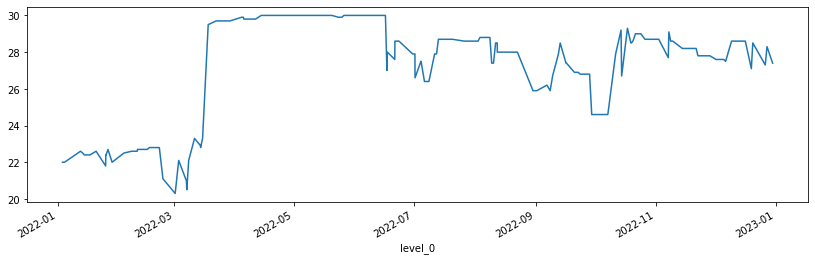

In [15]:
cid = 0
one_stock = stocks.xs(cid, level='cid')
print(f"Plotting stock {companies.iloc[cid].symbol}:") 
one_stock['value'].plot(figsize=(14,4))